# Hallingdal
## Setting up the model

We aim to configure a RIBASIM-model for Hallingdal river. Starts with the river upstream Hol II power plant

For documentation of Ribasim: https://ribasim.org/

### Step 1: Import packages
Before building the model we need to import some modules by running the following imports:

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from ribasim import Model, Node
from ribasim.nodes import basin, flow_boundary, tabulated_rating_curve
from shapely.geometry import Point

### Step 2: Setup paths and model configuration
Reference the paths of the Ribasim installation and model directory and define the time period (2001-01-01 until 2010-01-01) for the model simulation. Also read the path where the input data is located.
The coordinate reference system (CRS) is also required, and set to [EPSG:32633](https://epsg.io/32633), which means all coordinates are interpreted as being in WGS 84 / UTM zone 33N
The CRS is important for correctly placing Ribasim models on the map, but since this is a fictional model, it is not important.

In [ ]:
base_dir = Path().absolute()
data_path = base_dir / "Drammen/input/" #referencing your data input

starttime = "2001-01-01"
endtime = "2010-01-01"
model = Model(
    starttime=starttime,
    endtime=endtime,
    crs="EPSG:32633",
)


### Step 3: Read model topology
Two pandas dataframes are created. In 'subcatchment_topology' is the first column the subcatchment_ID and the second the ID of the downstream reservoir.
In 'reservoir_topology' is the first column reservori_ID and the second the ID of the downstream reservoirs. T

These two dataframes are used to define edges connecting nodes.

Finally lists of uniqe sub-catchment ids and reservoir ids are created and later used to define nodes. 
For the time, this topology is set manually. Next step is to read it from available shape-files.

In [ ]:
import numpy as np
subcatchment_topology=pd.DataFrame({'ID':[2393,1342,2210,2405,1565,4294,2153,2332,1084,2586,1566], 
                            'Downstream_res':[149,1028,1028,1028,1028,2942,100,2941,170,164,1029]})

reservoir_topology=pd.DataFrame({'ID':[149,1028,2942,2941,170,100,164], 
                            'Downstream_res':[1028,1029,2941,100,100,164,1028]})

model_reservoirs=pd.concat([subcatchment_topology['Downstream_res'],reservoir_topology['Downstream_res'],reservoir_topology['ID']]).unique()

model_catchments=subcatchment_topology['ID'].unique()

### Step 4: Read time series of flow boundaries for Hallingdal river basin
Reads daily time series of simulated runoff from the gridded HBV model calibrated to Drammen rover basin. Time series are read for the subcatchments listed in Step 3.

These will later be used to create flow boundaries.

All data are stored in the dataframe 'flowdata'

In [ ]:

from os import listdir
from os.path import isfile, join
from pandas import read_fwf
data_path = base_dir / "Drammen/input/" #referencing your data input

# Read the first file to get the dates.
i=0
fname_t=["hbv_0000",str(model_catchments[i]),".var"]
fname=''.join(fname_t)
datafile = data_path / fname
with open(datafile) as f:
    next(f)
    df = read_fwf(f,widths=[13, 16], names=["Date", "Q"])
year=pd.to_numeric(df["Date"].str.slice(0, 4))
month=pd.to_numeric(df["Date"].str.slice(4, 6))
day=pd.to_numeric(df["Date"].str.slice(6, 8))
mydates = pd.DataFrame([year.to_numpy(),month.to_numpy(),day.to_numpy()]).transpose()
mydates.columns = ['Year', 'Month', 'Day']
mydates=pd.to_datetime(mydates)
mycatchments = [str(s) for s in model_catchments] 
print(mycatchments)
flowdata = pd.DataFrame(columns=['Date'] + mycatchments)
flowdata['Date']=mydates
flowdata[mycatchments[i]] = df['Q']
for mc in mycatchments:
    fname_t=["hbv_0000",str(mc),".var"]
    fname=''.join(fname_t)
    datafile = data_path / fname    
    with open(datafile) as f:
        next(f)
        df = read_fwf(f,widths=[13, 16], names=["Date", "Q"])
    flowdata[mc]=df['Q']

### Step 5: Read geometry and names of sub-catchments/flow boundary nodes and calculate coordinates
Reads the geometry of all subcatchments and calculates the center of gravity to get name and coordinate for each flow boundary node

In [ ]:
import geopandas
#base_dir = Path().resolve()
cfile = base_dir / 'Drammen/Vannkraft/Vannkraft_Delfelt.shp'
subcatchments = geopandas.read_file(cfile, encoding='ISO-8859-1')

delfeltnr = subcatchments['delfeltNr'].values.tolist()
delfeltnr2 = [int(item) for item in mycatchments]

def find_matching_index(list1, list2):

    inverse_index = { element: index for index, element in enumerate(list1) }

    return [inverse_index[element]
        for index, element in enumerate(list2) if element in inverse_index]


mi=find_matching_index(delfeltnr, delfeltnr2) # [(0, 2), (1, 1), (2, 0)]

subcatchments_Drammen = subcatchments.iloc[mi]
cpoints=subcatchments_Drammen.centroid.to_crs(epsg=32633)
Subcatchment_info = pd.DataFrame({'Name':subcatchments_Drammen['delfeltNvn'],'ID':delfeltnr2, 'X':cpoints.x,'Y':cpoints.y})
Subcatchment_info=Subcatchment_info.reset_index()


### Step 6: Read geometry and names of reservoirs.
Reads reservoir area, lrv and hrv and regulation volume.

In [6]:

import geopandas
#base_dir = Path().resolve()
cfile = base_dir / 'Drammen/Vannkraft/Vannkraft_Magasin.shp'
print(cfile)
reservoirs = geopandas.read_file(cfile, encoding='ISO-8859-1')

magnr = reservoirs['magasinNr'].values.tolist()

def find_matching_index(list1, list2):
    inverse_index = { element: index for index, element in enumerate(list1) }
    return [inverse_index[element]
        for index, element in enumerate(list2) if element in inverse_index]

mi=find_matching_index(magnr, model_reservoirs) # [(0, 2), (1, 1), (2, 0)]

reservoirs_Hallingdal = reservoirs.iloc[mi]
#print(reservoirs_Hallingdal)
lowest=reservoirs_Hallingdal['lrv_moh'].values
highest=reservoirs_Hallingdal['hrv_moh'].values
harea=reservoirs_Hallingdal['areal_km2'].values
rvolume=reservoirs_Hallingdal['volOppdemt'].values

mpoints=reservoirs_Hallingdal.centroid.to_crs(epsg=32633)
print(mpoints)
#(highest-lowest)*(harea+larea)/2 = rvolume
#larea = 2*rvolume/(highest-lowest)-harea 
larea=harea*0.5
lowest = highest-2*rvolume/(harea-larea)

resid = [int(s) for s in reservoirs_Hallingdal['magasinNr']] 

Reservoirs = pd.DataFrame({'Name':reservoirs_Hallingdal['magNavn'],'ID':resid, 'X':mpoints.x,'Y':mpoints.y,'larea':larea,'harea':harea,'rvoume':rvolume,'hrv':highest,'lrv':lowest})

C:\Deltares\rib_course\Drammen\Vannkraft\Vannkraft_Magasin.shp
1382    POINT (110247.258 6749394.382)
1375    POINT (130323.227 6738855.057)
1379    POINT (119996.627 6757222.702)
1378    POINT (130868.787 6749158.976)
2723    POINT (124755.138 6752669.718)
1377    POINT (134607.398 6749363.122)
1376    POINT (131320.589 6744601.792)
1374    POINT (134206.692 6737885.072)
dtype: geometry
   index                                 Name    ID              X  \
0   1382                          Strandavatn   149  110247.257563   
1   1375                          Hovsfjorden  1028  130323.226958   
2   1379               NEDRE/ ÃVRE STOLSVATN  2942  119996.626724   
3   1378                             RÃ¸dugen   100  130868.786879   
4   2723  FROSEN, BUVATNET, MJÃVATNET (STOLS  2941  124755.137523   
5   1377                           BergsjÃ¸en   170  134607.398248   
6   1376                        Varaldsetvatn   164  131320.589195   
7   1374                          Holsfjorden  10

C:\Users\koe\AppData\Local\Temp\ipykernel_32888\218909483.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mpoints=reservoirs_Hallingdal.centroid.to_crs(epsg=32633)


### Step 7: build flowboundary nodes

I start to bulid the flow boundary nodes for all subcatchments. Flowboundaries are stored in a dictionary using catchment-IS as an identifyer. all flowboundaries in the model also get the subcatchment-ID as identifyer.

In [7]:
flowboundaries={}
for i in range(Subcatchment_info.shape[0]):
    flowboundaries[str(Subcatchment_info.ID[i])] = model.flow_boundary.add(
        Node(10000000+Subcatchment_info.ID[i], Point(Subcatchment_info.X[i], Subcatchment_info.Y[i]), name=Subcatchment_info.Name[i]), 
        [flow_boundary.Time(
            time=flowdata['Date'], 
            flow_rate=flowdata[str(Subcatchment_info.ID[i])]
        )]
    )


### Step 8: I continue by building basin nodes for all reservoirs

In [8]:
reservoirnodes={}
for i in range(Reservoirs.shape[0]):
    reservoirnodes[str(Reservoirs.ID[i])] = model.basin.add(
        Node(20000000+Reservoirs.ID[i], Point(Reservoirs.X[i],Reservoirs.Y[i]), name=Reservoirs.Name[i]),
        [
            basin.Profile(area=[Reservoirs.larea[i], Reservoirs.harea[i]], level=[Reservoirs.lrv[i], Reservoirs.hrv[i]]),
            basin.State(level=[(Reservoirs.lrv[i]+Reservoirs.hrv[i])/2]),
            basin.Time(time=[starttime, endtime]),
        ],
    )


### Step 9: I continue to build tbulated rating curve nodes for all reservoirs


In [10]:
ratingcurvenodes={}
for i in range(Reservoirs.shape[0]):
    ratingcurvenodes[str(Reservoirs.ID[i])] = model.tabulated_rating_curve.add(
        Node(30000000+Reservoirs.ID[i], Point(Reservoirs.X[i],Reservoirs.Y[i]), name=Reservoirs.Name[i]),
        [
            tabulated_rating_curve.Static(
                level=[Reservoirs.lrv[i], Reservoirs.hrv[i]],
                flow_rate=[0.0, flowdata[str(Subcatchment_info.ID[i])].max()],
            )
        ],
    )


### Step 10: Now I start to build the edges connecting all nodes.
First step is connect flow boundary nodes to basin nodes

In [12]:
for i in range(subcatchment_topology.shape[0]):
    model.edge.add(flowboundaries[str(subcatchment_topology.ID[i])], reservoirnodes[str(subcatchment_topology.Downstream_res[i])], 
                   name='_'.join([str(subcatchment_topology.ID[i]),str(subcatchment_topology.Downstream_res[i])]))


Nex step is to reservoirs and rating curve nodes

In [13]:
for i in range(Reservoirs.shape[0]):
    model.edge.add(reservoirnodes[str(Reservoirs.ID[i])], ratingcurvenodes[str(Reservoirs.ID[i])], 
                   name='_'.join([str(Reservoirs.ID[i]),str(Reservoirs.ID[i])]))

Finally link rating curve nodes to downstream basin node

In [14]:
for i in range(reservoir_topology.shape[0]):
    model.edge.add(ratingcurvenodes[str(reservoir_topology.ID[i])], reservoirnodes[str(reservoir_topology.Downstream_res[i])], 
                   name='_'.join([str(reservoir_topology.ID[i]),str(reservoir_topology.Downstream_res[i])]))

Create a terminal node

In [15]:
i=Reservoirs.shape[0]-1
Terminalnode = model.terminal.add(Node(1000002, Point(Reservoirs.X[i]+10000, Reservoirs.Y[i]-10000), name="terminal"))
model.edge.add(ratingcurvenodes[str(Reservoirs.ID[i])], Terminalnode, 
                   name='Terminaledge')

### Step 11: Visualization and model execution
Plot the schematization.

<Axes: >

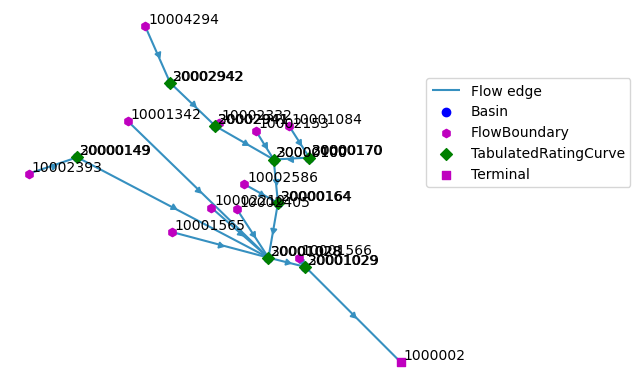

In [16]:
model.plot()

### Step 5: Configuration
Write the model configuration to the `TOML` file.
Name the output file `Hallingdal/ribasim.toml`:

In [17]:
toml_path = base_dir / "Hallingdal/ribasim.toml"
model.write(toml_path)
cli_path = base_dir / "ribasim/ribasim.exe"

### Step 6: Run the model
After running `model.write` a subfolder `Exercise_1` is created, which contains the model input data and configuration.
Have a look at it. 

The folder contains:
- ribasim.toml: The model configuration
- database.gpkg: A GeoPackage containing the network geometry and input data of the nodes used.

The following command in cell [15] calls the model to run ribasim. Run the model again. The run will take a few seconds.
After a succesfull run check your `Exercise_1` folder again. What did you gain?

In [ ]:
%%cmd
ribasim\ribasim "Hallingdal/ribasim.toml"

Microsoft Windows [Version 10.0.26100.2894]
(c) Microsoft Corporation. Med enerett.

C:\Deltares\rib_course>ribasim\ribasim "Hallingdal/ribasim.toml"


┌ Info: Starting a Ribasim simulation.
│   cli.ribasim_version = "2024.11.0"
│   starttime = 2001-01-01T00:00:00
└   endtime = 2010-01-01T00:00:00
Simulating   0%|█                                       |  ETA: N/A
Simulating   0%|█                                       |  ETA: 349807.87 days
Simulating   0%|█                                       |  ETA: 50937.89 days
Simulating   0%|█                                       |  ETA: 6299.59 days
Simulating   0%|█                                       |  ETA: 296.22 days
Simulating   0%|█                                       |  ETA: 7:10:49
Simulating   0%|█                                       |  ETA: 2:03:08
Simulating   0%|█                                       |  ETA: 1:11:50
Simulating   1%|█                                       |  ETA: 0:45:24
Simulating   1%|█                                       |  ETA: 0:37:25
Simulating   1%|█                                       |  ETA: 0:28:04
Simulating   1%|█                          

### Step 7: Post-processing results
The nice thing about Python is that it gives `you`, the modeller/researcher/analist etc. a platform to view results the way you prefer. Below you'll see an example of such a view. Here the script reads the Arrow files and plots the simulated flows from different edges and the levels and storages at our `confluence point`. What do you see in your outputs?

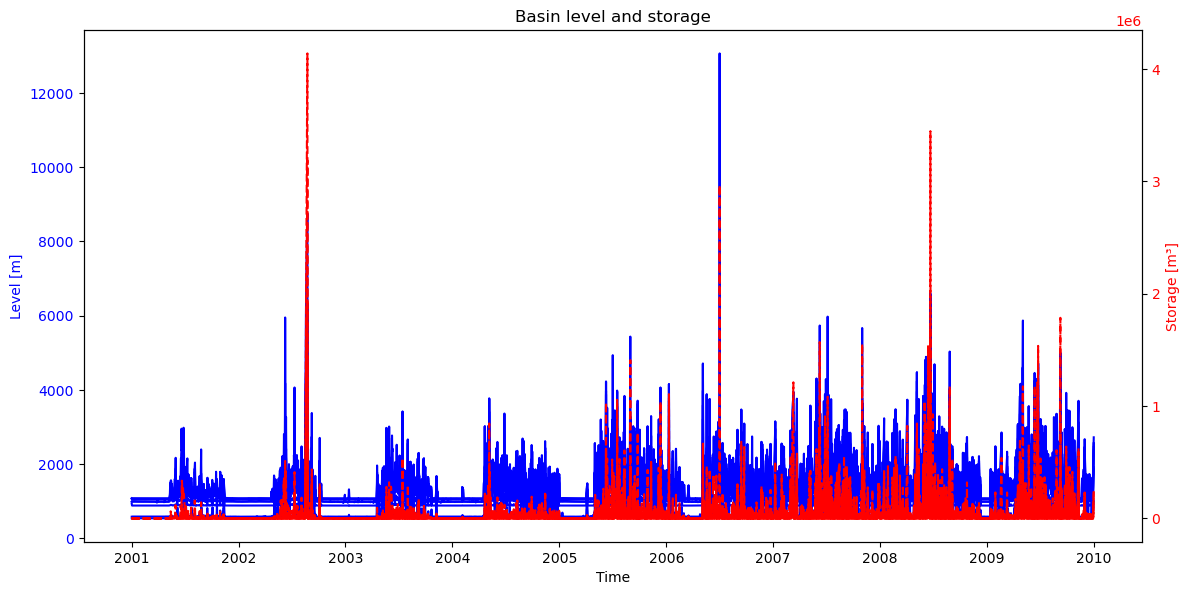

In [ ]:
df_basin = pd.read_feather(
    base_dir / "Hallingdal/results/basin.arrow", dtype_backend="pyarrow"
)

# Create pivot tables and plot for Basin data
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)

# Plot level and storage on the same graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot level on the primary y-axis
color = "b"
ax1.set_xlabel("Time")
ax1.set_ylabel("Level [m]", color=color)
ax1.plot(df_basin_wide.index, df_basin_wide["level"], color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create a secondary y-axis for storage
ax2 = ax1.twinx()
color = "r"
ax2.set_ylabel("Storage [m³]", color="r")
ax2.plot(df_basin_wide.index, df_basin_wide["storage"], linestyle="--", color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # Adjust layout to fit labels
plt.title("Basin level and storage")
plt.show()

### Explanation
The figure above shows the storage and levels in the Basin node.

To accurately represent the relationship between water levels and discharge rates at this confluence, a TabulatedRatingCurve is used.
This setup mimics the behavior of a gate or spillway, allowing us to model how varying water levels influence flow rates at the confluence.
Since the basin node is functioning as a `confluence` rather than a `storage reservoir`, the simulated water levels and storage trends will closely follow the inflow patterns.
This is because there is no net change in storage; all incoming water is balanced by outgoing flow.

### Step 8: Results Flows

De code below will illustrate a graph with all the flows in the edges. Run it and see for yourself if the results make sense to you.

In [ ]:
# Plot flow data
# Read the flow results
df_flow = pd.read_feather(
    base_dir / "Hallingsal/results/flow.arrow", dtype_backend="pyarrow"
)
# Add the edge names and then remove unnamed edges if you have any
df_flow["name"] = model.edge.df["name"].loc[df_flow["edge_id"]].to_numpy()
df_flow = df_flow[df_flow["name"].astype(bool)]

# Create a pivot table
pivot_flow = df_flow.pivot_table(index="time", columns="name", values="flow_rate")

line_styles = ["-", "--", "-", "-."]
num_styles = len(line_styles)

fig, ax = plt.subplots(figsize=(12, 6))
for i, column in enumerate(pivot_flow.columns):
    pivot_flow[column].plot(
        ax=ax, linestyle=line_styles[i % num_styles], linewidth=1.5, alpha=0.8
    )

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Flow [m³/s]")
ax.legend(title="Edge")
plt.title("Flow")
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Deltares\\rib_course\\Hallingsal\\results\\flow.arrow'

### Explanation
The figure above shows the discharges in $\text{m}^3/\text{s}$ on each edge.

Edge `conf2tbr_conf` represents the flow from the confluence to the TabulatedRatingCurve and edge `sea` represents the flow from the TabulatedRatingCurve to the Terminal.
Both show the same discharge over time.
Which is expected in a natural flow environment, as what is coming into the confluence must come out.